In [25]:
from models.VAE_for_RUL_pediction import *

In [35]:
def viz_latent_space(encoder, data, targets=[], epoch='Final', save=False, show=True):
    z, _, _  = encoder.predict(data)
    plt.figure(figsize=(8, 10))
    if len(targets)>0:
        plt.scatter(z[:, 0], z[:, 1], c=targets)
    else:
        plt.scatter(z[:, 0], z[:, 1])
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.colorbar()
    if show:
        plt.show()
    if save:
        plt.savefig('../images/latent_space_epoch'+str(epoch)+'.png')
    return z

def get_data(dataset, sensors, sequence_length, alpha, threshold):
	# files
	dir_path = '../data/'
	train_file = 'train_'+dataset+'.txt'
	test_file = 'test_'+dataset+'.txt'
    # columns
	index_names = ['unit_nr', 'time_cycles']
	setting_names = ['setting_1', 'setting_2', 'setting_3']
	sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
	col_names = index_names + setting_names + sensor_names
    # data readout
	train = pd.read_csv((dir_path+train_file), sep=r'\s+', header=None, 
					 names=col_names)
	test = pd.read_csv((dir_path+test_file), sep=r'\s+', header=None, 
					 names=col_names)
	y_test = pd.read_csv((dir_path+'RUL_'+dataset+'.txt'), sep=r'\s+', header=None, 
					 names=['RemainingUsefulLife'])

    # create RUL values according to the piece-wise target function
	train = add_remaining_useful_life(train)
	train['RUL'].clip(upper=threshold, inplace=True)

    # remove unused sensors
	drop_sensors = [element for element in sensor_names if element not in sensors]

    # scale with respect to the operating condition
	X_train_pre = add_operating_condition(train.drop(drop_sensors, axis=1))
	X_test_pre = add_operating_condition(test.drop(drop_sensors, axis=1))
	X_train_pre, X_test_pre = condition_scaler(X_train_pre, X_test_pre, sensors)

    # exponential smoothing
	X_train_pre= exponential_smoothing(X_train_pre, sensors, 0, alpha)
	X_test_pre = exponential_smoothing(X_test_pre, sensors, 0, alpha)

	# train-val split
	gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
	# generate the train/val for *each* sample -> for that we iterate over the train and val units we want
	# this is a for that iterates only once and in that iterations at the same time iterates over all the values we want,
	# i.e. train_unit and val_unit are not a single value but a set of training/vali units
	for train_unit, val_unit in gss.split(X_train_pre['unit_nr'].unique(), groups=X_train_pre['unit_nr'].unique()): 
		train_unit = X_train_pre['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
		val_unit = X_train_pre['unit_nr'].unique()[val_unit]

		x_train = gen_data_wrapper(X_train_pre, sequence_length, sensors, train_unit)
		y_train = gen_label_wrapper(X_train_pre, sequence_length, ['RUL'], train_unit)
		
		x_val = gen_data_wrapper(X_train_pre, sequence_length, sensors, val_unit)
		y_val = gen_label_wrapper(X_train_pre, sequence_length, ['RUL'], val_unit)

	# create sequences for test 
	test_gen = (list(gen_test_data(X_test_pre[X_test_pre['unit_nr']==unit_nr], sequence_length, sensors, -99.))
			   for unit_nr in X_test_pre['unit_nr'].unique())
	x_test = np.concatenate(list(test_gen)).astype(np.float32)
	
	return x_train, y_train, x_val, y_val, x_test, y_test['RemainingUsefulLife']

class save_latent_space_viz(Callback):
	def __init__(self, model, data, target):
		self.model = model
		self.data = data
		self.target = target
	
	def on_train_begin(self, logs={}):
		self.best_val_loss = 100000
		
	def on_epoch_end(self, epoch, logs=None):
		encoder = self.model.layers[0]
		if logs.get('val_loss') < self.best_val_loss:
			self.best_val_loss = logs.get('val_loss')
			viz_latent_space(encoder, self.data, self.target, epoch, True, False)
	
def get_callbacks(model, data, target):
	model_callbacks = [
		EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30),
        ModelCheckpoint(filepath='./checkpoints/checkpoint',monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=True),
		TensorBoard(log_dir='./logs'),
        save_latent_space_viz(model, data, target)
	]
	return model_callbacks

In [36]:
dataset = "FD001"
# sensors to work with: T30, T50, P30, PS30, phi
sensors = ['s_3', 's_4', 's_7', 's_11', 's_12']
# windows length
sequence_length = 30
# smoothing intensity
alpha = 0.1
# max RUL
threshold = 125   
x_train, y_train, x_val, y_val, x_test, y_test = get_data(dataset, sensors, 
                sequence_length, alpha, threshold)

In [37]:
timesteps = x_train.shape[1]
input_dim = x_train.shape[2]
intermediate_dim = 300
batch_size = 128
latent_dim = 2
epochs = 10
optimizer = 'adam'
	
RVE = create_model(timesteps, 
		input_dim, 
		intermediate_dim, 
		batch_size, 
		latent_dim, 
		epochs, 
		optimizer,
			)	
	# Callbacks for training
model_callbacks = get_callbacks(RVE, x_train, y_train)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 30, 5)]              0         []                            
                                                                                                  
 masking_2 (Masking)         (None, 30, 5)                0         ['encoder_input[0][0]']       
                                                                                                  
 bidirectional_2 (Bidirecti  (None, 600)                  734400    ['masking_2[0][0]']           
 onal)                                                                                            
                                                                                                  
 dense_6 (Dense)             (None, 2)                    1202      ['bidirectional_2[0][0]'

## Training VAE model

Epoch 1/10

Epoch 1: val_loss improved from inf to 50.59558, saving model to ./checkpoints\checkpoint
446/446 [==============================] - 38s 63ms/step
112/112 - 126s - loss: 6127.5532 - kl_loss: 135.8443 - reg_loss: 5991.7070 - val_loss: 50.5956 - val_kl_loss: 13.5925 - val_reg_loss: 37.0031 - 126s/epoch - 1s/step
Epoch 2/10

Epoch 2: val_loss did not improve from 50.59558
112/112 - 56s - loss: 3332.4536 - kl_loss: 119.2245 - reg_loss: 3213.2307 - val_loss: 69.4869 - val_kl_loss: 9.0913 - val_reg_loss: 60.3956 - 56s/epoch - 498ms/step
Epoch 3/10

Epoch 3: val_loss improved from 50.59558 to 37.89697, saving model to ./checkpoints\checkpoint
446/446 [==============================] - 23s 52ms/step
112/112 - 80s - loss: 1954.5494 - kl_loss: 82.5319 - reg_loss: 1872.0170 - val_loss: 37.8970 - val_kl_loss: 3.7326 - val_reg_loss: 34.1643 - 80s/epoch - 716ms/step
Epoch 4/10

Epoch 4: val_loss improved from 37.89697 to 21.42303, saving model to ./checkpoints\checkpoint
446/446 [=======

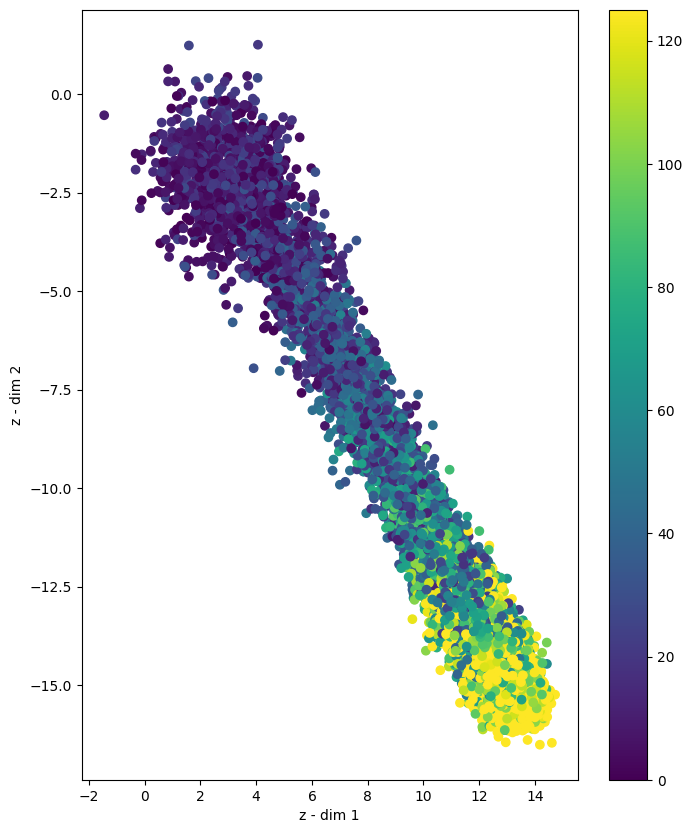

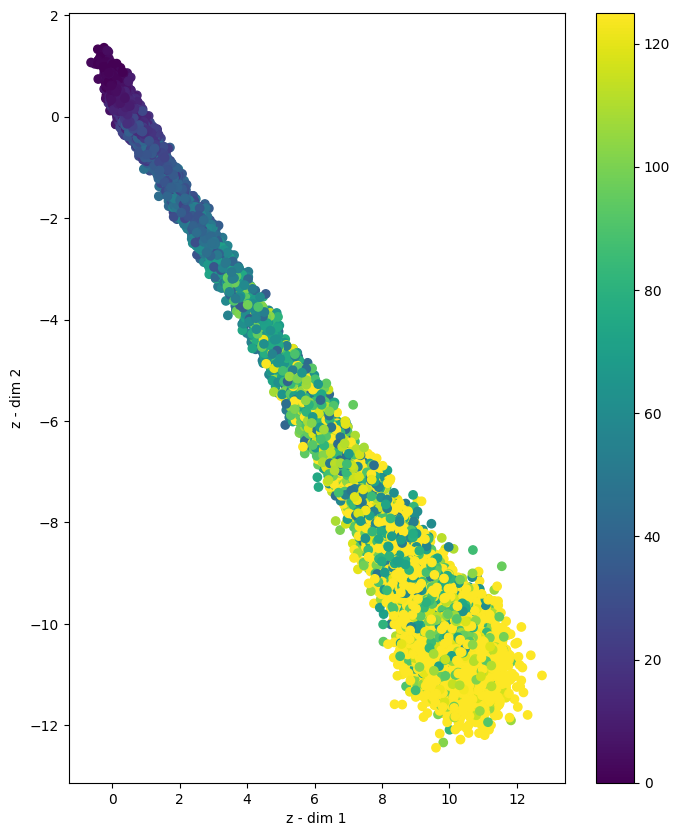

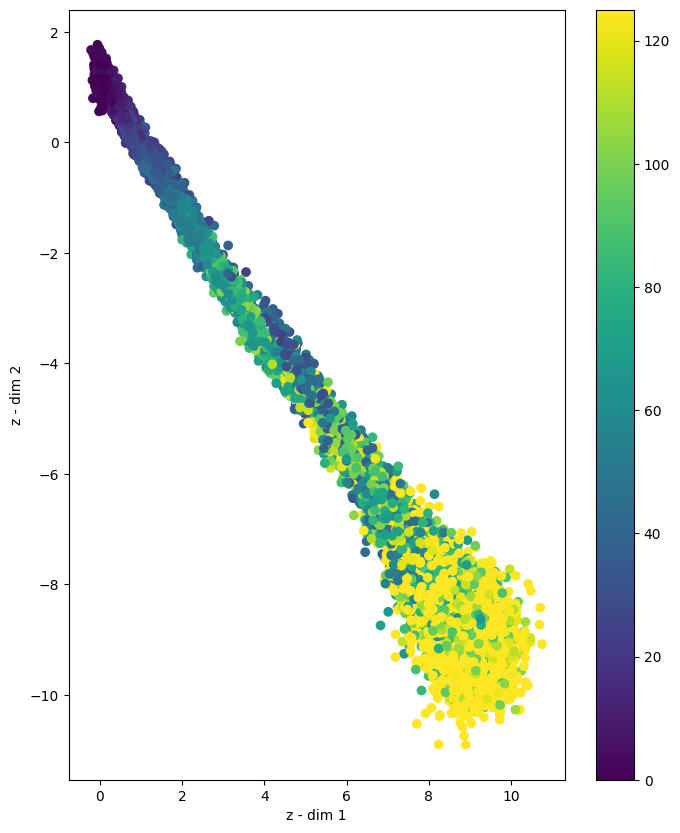

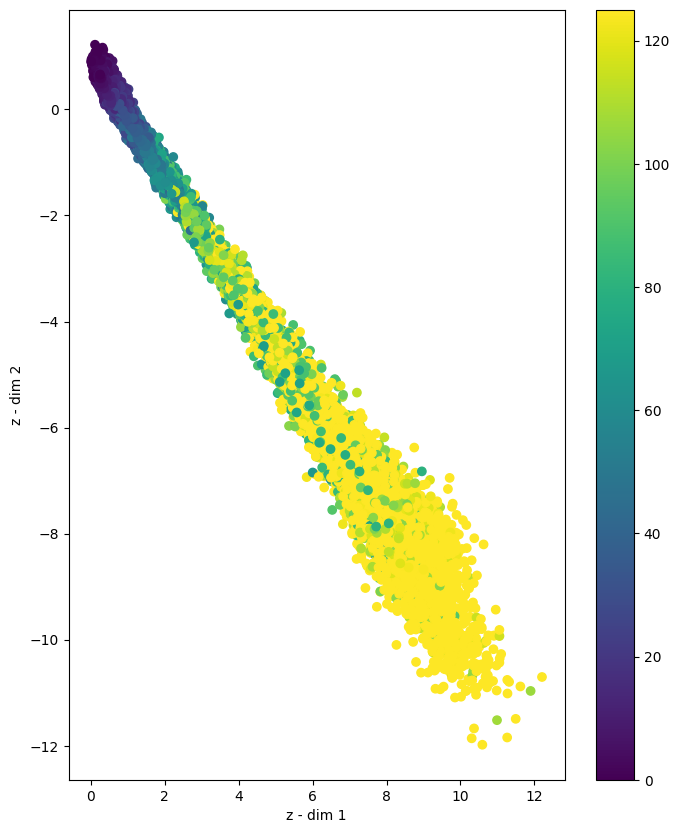

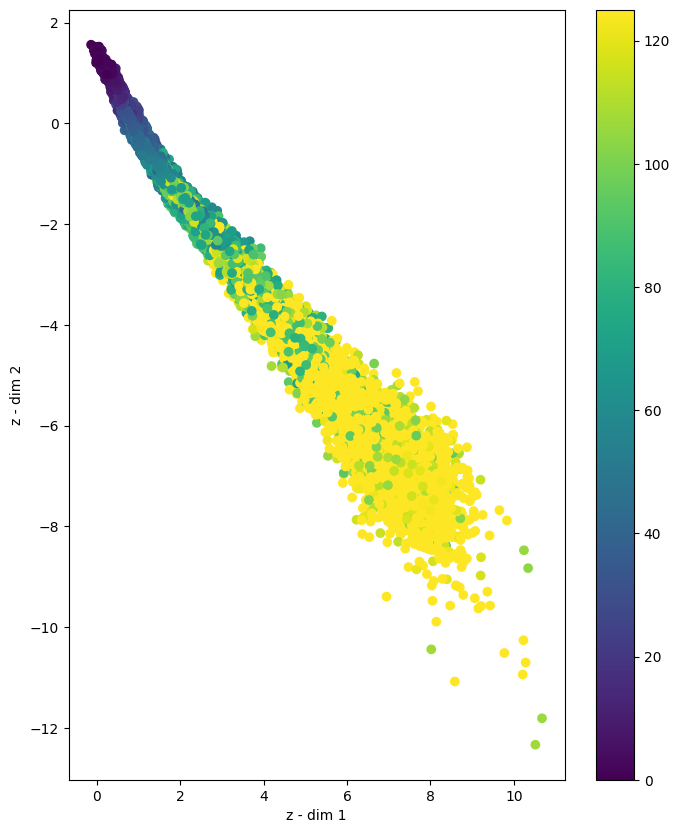

In [38]:
results = RVE.fit(x_train, y_train,
			shuffle=True,
			epochs=epochs,
			batch_size=batch_size,
			validation_data= (x_val, y_val),
			callbacks=model_callbacks, verbose=2)

## evalute the model


555/555 [==============================] - 41s 74ms/step


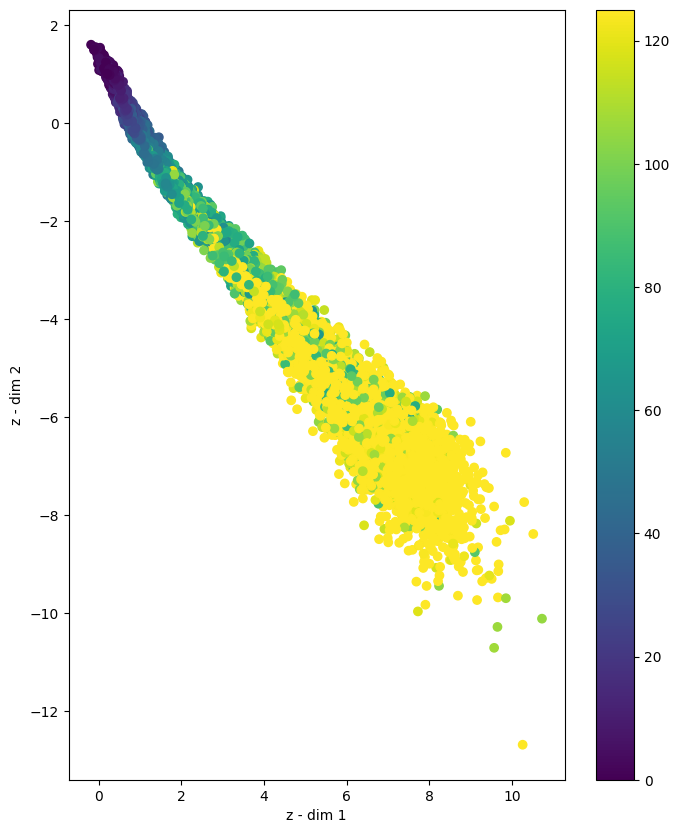

4/4 [==============================] - 0s 48ms/step


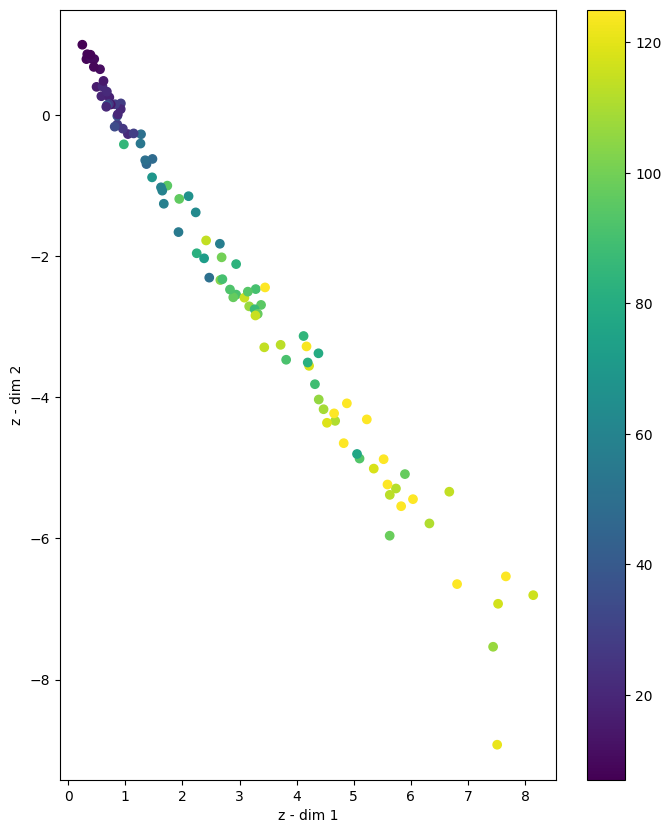

4/4 [==============================] - 0s 4ms/step
train set RMSE:16.546579360961914, R2:0.8433016318681128
test set RMSE:16.415477468658274, R2:0.8439558490554079


In [39]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

def score(y_true, y_hat):
  res = 0
  for true, hat in zip(y_true, y_hat):
    subs = hat - true
    if subs < 0:
      res = res + np.exp(-subs/10)[0]-1
    else:
      res = res + np.exp(subs/13)[0]-1
  print("score: ", res)

def results(path, x_train, y_train, x_test, y_test):
    # Get model
    encoder, regressor = get_model(path)
    # Latent space
    train_mu = viz_latent_space(encoder, x_train, y_train)
    test_mu = viz_latent_space(encoder, x_test, y_test)
    # Evaluate
    y_hat_train = regressor.predict(train_mu)
    y_hat_test = regressor.predict(test_mu)

    evaluate(y_train, y_hat_train, 'train')
    evaluate(y_test, y_hat_test, 'test')
    score(y_test, y_hat_test)
RVE.load_weights('./checkpoints/checkpoint')
train_mu = viz_latent_space(RVE.encoder, np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))
test_mu = viz_latent_space(RVE.encoder, x_test, y_test.clip(upper=threshold))
# Evaluate
y_hat_train = RVE.regressor.predict(train_mu)
y_hat_test = RVE.regressor.predict(test_mu)

evaluate(np.concatenate((y_train, y_val)), y_hat_train, 'train')
evaluate(y_test, y_hat_test, 'test')

In [46]:
y_hat_test

array([[105.30769  ],
       [105.72803  ],
       [ 57.140537 ],
       [ 79.71667  ],
       [ 89.68609  ],
       [104.13767  ],
       [ 98.20926  ],
       [ 93.07498  ],
       [102.63341  ],
       [ 68.061844 ],
       [ 89.59005  ],
       [ 98.80522  ],
       [ 62.794243 ],
       [ 92.03869  ],
       [ 86.83477  ],
       [ 98.144295 ],
       [ 44.145836 ],
       [ 29.488922 ],
       [ 92.78462  ],
       [ 16.063934 ],
       [ 82.303185 ],
       [106.11202  ],
       [105.28539  ],
       [ 30.97472  ],
       [105.68261  ],
       [102.39789  ],
       [ 69.658455 ],
       [ 93.406906 ],
       [ 91.35162  ],
       [ 90.863525 ],
       [  4.3613076],
       [ 53.307835 ],
       [101.41364  ],
       [ -1.2724558],
       [ 12.401228 ],
       [ 20.462454 ],
       [ 39.86391  ],
       [ 84.56899  ],
       [106.75335  ],
       [ 33.794456 ],
       [ 23.705654 ],
       [  7.3307824],
       [ 62.486877 ],
       [101.899284 ],
       [ 79.66341  ],
       [ 5

### RUL score

In [49]:
from sksurv.metrics import concordance_index_censored

def concordance_index(y_true, y_pred):
    event_indicator = y_true < threshold
    return concordance_index_censored(event_indicator, y_true, y_pred)

def evaluate_survival(y_true, y_hat, label='test'):
    ci = concordance_index(y_true, y_hat.ravel())  # Flatten y_hat to make it 1D
    print('{} set CI:{}'.format(label, ci))

evaluate_survival(y_test, y_hat_test, 'test')


test set CI:(0.12777777777777777, 621, 4239, 0, 0)
